## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

from xgboost import XGBClassifier

## Chargement du dataset

In [2]:
df = pd.read_csv('dataset_V2.csv')
# On retire les lignes ou il manque des données
df = df.dropna(inplace=False)

In [3]:
df

,Date,MatchWeek,HomeTeam,AwayTeam,FTR,HomeYellowlMade,AwayYellowMade,HomeRedMade,AwayRedMade,HomeFoulMade,...,Home5GW,Home3GL,Home5GL,Away3GW,Away5GW,Away3GL,Away5GL,WHH,WHD,WHA
0,19/08/00,1,Charlton,Man City,H,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,2.10,3.20,3.10
1,19/08/00,1,Chelsea,West Ham,H,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1.44,3.60,6.50
2,19/08/00,1,Coventry,Middlesbrough,A,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,2.30,3.20,2.62
3,19/08/00,1,Derby,Southampton,D,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,2.00,3.20,3.20
4,19/08/00,1,Leeds,Everton,H,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1.61,3.50,4.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31001,14/05/2022,34,Mainz,Ein Frankfurt,D,60.0,61.0,4.0,1.0,487.0,...,0,0,0,0,0,0,0,1.62,4.33,4.75
31002,14/05/2022,34,M'gladbach,Hoffenheim,H,66.0,73.0,1.0,0.0,350.0,...,0,0,0,0,0,0,0,2.05,4.20,3.00
31003,14/05/2022,34,Stuttgart,FC Koln,H,63.0,64.0,2.0,1.0,353.0,...,0,0,0,1,0,0,0,2.15,3.90,3.00
31004,14/05/2022,34,Union Berlin,Bochum,H,60.0,53.0,1.0,2.0,411.0,...,0,0,0,0,0,0,0,1.38,4.80,7.50


On groupe les résultats des matchs et on garde le même nombre de victoires, matchs nuls et défaites

In [4]:
groupes = df.groupby('FTR')
taille_echantillon = min([len(groupe) for _, groupe in groupes])
df = pd.concat([groupe.sample(taille_echantillon) for _, groupe in groupes])

In [5]:
df

,Date,MatchWeek,HomeTeam,AwayTeam,FTR,HomeYellowlMade,AwayYellowMade,HomeRedMade,AwayRedMade,HomeFoulMade,...,Home5GW,Home3GL,Home5GL,Away3GW,Away5GW,Away3GL,Away5GL,WHH,WHD,WHA
25347,01/03/2020,27,Nantes,Lille,A,46.0,47.0,2.0,3.0,356.0,...,0,0,0,1,0,0,0,3.00,3.00,2.55
23376,10/01/15,20,Reims,St Etienne,A,33.0,29.0,3.0,2.0,252.0,...,0,0,0,1,0,0,0,4.00,3.00,2.10
24395,30/09/17,8,Rennes,Caen,A,11.0,10.0,1.0,1.0,93.0,...,0,0,0,1,0,0,0,1.95,3.40,4.00
28665,23/11/14,12,Stuttgart,Augsburg,A,19.0,25.0,0.0,0.0,161.0,...,0,0,0,0,0,0,0,2.60,3.10,2.80
3574,17/12/11,16,Wolves,Stoke,A,29.0,26.0,0.0,0.0,142.0,...,0,0,0,0,0,0,0,2.50,3.30,2.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12862,20/04/2019,33,Celta,Girona,H,77.0,70.0,6.0,3.0,393.0,...,0,0,0,0,0,0,0,1.95,3.75,3.70
7976,13/05/06,38,Villarreal,Santander,H,106.0,125.0,5.0,10.0,631.0,...,0,0,0,0,0,0,0,1.36,4.00,7.00
11978,30/01/17,20,Las Palmas,Valencia,H,48.0,55.0,3.0,3.0,219.0,...,0,0,0,0,0,0,0,2.50,3.50,2.80
20285,01/12/2021,15,Inter,Spezia,H,30.0,29.0,0.0,2.0,180.0,...,0,0,0,0,0,0,0,1.20,7.00,15.00


On retire certains paramètres

In [6]:
df_equipe = df[['HomeTeam', 'AwayTeam', 'FTR', 'WHH', 'WHD', 'WHA']]
#df = df.drop(['Date', 'HomeTeam', 'AwayTeam', 'FTR','HomeFormPtsStr','AwayFormPtsStr','MatchWeek', 'WHH', 'WHD', 'WHA'], axis=1)
df = df.drop(['Date', 'HomeTeam', 'AwayTeam', 'FTR','HomeFormPtsStr','AwayFormPtsStr','MatchWeek'], axis=1)
df

,HomeYellowlMade,AwayYellowMade,HomeRedMade,AwayRedMade,HomeFoulMade,HomeFoulConceded,AwayFoulMade,AwayFoulConceded,HomeCornerMade,HomeCornerConceded,...,HomeFormPts,AwayFormPts,Home3GW,Home5GW,Home3GL,Home5GL,Away3GW,Away5GW,Away3GL,Away5GL
25347,46.0,47.0,2.0,3.0,356.0,335.0,351.0,347.0,141.0,117.0,...,5,12,0,0,0,0,1,0,0,0
23376,33.0,29.0,3.0,2.0,252.0,253.0,261.0,251.0,83.0,79.0,...,9,13,0,0,0,0,1,0,0,0
24395,11.0,10.0,1.0,1.0,93.0,107.0,91.0,97.0,45.0,30.0,...,5,12,0,0,0,0,1,0,0,0
28665,19.0,25.0,0.0,0.0,161.0,161.0,165.0,164.0,65.0,45.0,...,4,6,0,0,0,0,0,0,0,0
3574,29.0,26.0,0.0,0.0,142.0,182.0,180.0,163.0,82.0,116.0,...,6,9,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12862,77.0,70.0,6.0,3.0,393.0,425.0,459.0,465.0,131.0,170.0,...,7,3,0,0,0,0,0,0,0,0
7976,106.0,125.0,5.0,10.0,631.0,724.0,836.0,725.0,153.0,187.0,...,5,6,0,0,0,0,0,0,0,0
11978,48.0,55.0,3.0,3.0,219.0,314.0,281.0,309.0,89.0,87.0,...,5,7,0,0,0,0,0,0,0,0
20285,30.0,29.0,0.0,2.0,180.0,173.0,181.0,180.0,82.0,60.0,...,13,4,0,0,0,0,0,0,0,0


## Classification

La donnée à prédire est `FTR`, le résultat du match

In [7]:
X = df
y = df_equipe['FTR']

On remplace les valeurs textuelles du résultat par des chiffres

In [8]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
encoded_dict = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

On split le dataset (80% train, 20% test) puis on échelonne les valeurs

In [ ]:
X = X.astype(np.float32)
y = y.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Modèles de classification

Régression Logistique

In [ ]:
clf_RL = LogisticRegression(random_state=1)
clf_RL.fit(X_train, y_train)

y_pred_RL = clf_RL.predict(X_test)

accuracy_RL = clf_RL.score(X_test, y_test)
results = cross_validate(estimator=clf_RL,X=X,y=y,cv=5,scoring='accuracy')
accuracy_RL_cross = np.mean(results['test_score'])

Arbre Décisionel

In [11]:
clf_DT = DecisionTreeClassifier(random_state=1)
clf_DT.fit(X_train, y_train)

y_pred_DT = clf_DT.predict(X_test)

accuracy_DT = clf_DT.score(X_test, y_test)
results = cross_validate(estimator=clf_DT,X=X,y=y,cv=5,scoring='accuracy')
accuracy_DT_cross = np.mean(results['test_score'])

KNN

In [12]:
clf_KNN = KNeighborsClassifier(n_neighbors=8)
clf_KNN.fit(X_train, y_train)

y_pred_KNN = clf_KNN.predict(X_test)

accuracy_KNN = clf_KNN.score(X_test, y_test)
results = cross_validate(estimator=clf_KNN,X=X,y=y,cv=5,scoring='accuracy')
accuracy_KNN_cross = np.mean(results['test_score'])

Random Forest

In [13]:
clf_RF = RandomForestClassifier(max_depth=2, random_state=1)
clf_RF.fit(X_train, y_train)

y_pred_RF = clf_RF.predict(X_test)

accuracy_RF = clf_RF.score(X_test, y_test)
results = cross_validate(estimator=clf_RF,X=X,y=y,cv=5,scoring='accuracy')
accuracy_RF_cross = np.mean(results['test_score'])

SVM

In [14]:
clf_SVM = SVC(kernel = 'rbf',random_state = 1)
clf_SVM.fit(X_train, y_train)

y_pred_SVM = clf_SVM.predict(X_test)

accuracy_SVM = clf_SVM.score(X_test, y_test)
results = cross_validate(estimator=clf_SVM,X=X,y=y,cv=3,scoring='accuracy')
accuracy_SVM_cross = np.mean(results['test_score'])

XGBoost

In [15]:
clf_XGB = XGBClassifier(seed=1)
clf_XGB.fit(X_train, y_train)

y_pred_XGB = clf_XGB.predict(X_test)

accuracy_XGB = clf_XGB.score(X_test, y_test)
results = cross_validate(estimator=clf_XGB,X=X,y=y,cv=5,scoring='accuracy')
accuracy_XGB_cross = np.mean(results['test_score'])

Réseau de Neurones

In [18]:
# Création du modèle séquentiel
model = Sequential()

model.add(Dense(256, activation='relu', input_shape=(41,), kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))

#model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
#model.add(Dropout(0.7))

model.add(Dense(128, activation='tanh', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.2))

model.add(Dense(64, activation='tanh', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.2))

model.add(Dense(32, activation='tanh', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.2))

model.add(Dense(3, activation='softmax'))

# Compilation du modèle
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
#model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# Affichage d'un résumé du modèle
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               9984      
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)               

Epoch 1/100


2023-03-20 11:57:01.550085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-20 11:57:04.058195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


229/229 - 3s - loss: 1.7382 - accuracy: 0.4100 - val_loss: 1.4588 - val_accuracy: 0.4596 - 3s/epoch - 14ms/step
Epoch 2/100
229/229 - 2s - loss: 1.3647 - accuracy: 0.4336 - val_loss: 1.2614 - val_accuracy: 0.4561 - 2s/epoch - 10ms/step
Epoch 3/100
229/229 - 2s - loss: 1.2296 - accuracy: 0.4401 - val_loss: 1.1800 - val_accuracy: 0.4490 - 2s/epoch - 9ms/step
Epoch 4/100
229/229 - 2s - loss: 1.1613 - accuracy: 0.4537 - val_loss: 1.1292 - val_accuracy: 0.4580 - 2s/epoch - 9ms/step
Epoch 5/100
229/229 - 2s - loss: 1.1237 - accuracy: 0.4466 - val_loss: 1.1010 - val_accuracy: 0.4547 - 2s/epoch - 10ms/step
Epoch 6/100
229/229 - 2s - loss: 1.0968 - accuracy: 0.4522 - val_loss: 1.0780 - val_accuracy: 0.4599 - 2s/epoch - 9ms/step
Epoch 7/100
229/229 - 2s - loss: 1.0820 - accuracy: 0.4426 - val_loss: 1.0733 - val_accuracy: 0.4503 - 2s/epoch - 9ms/step
Epoch 8/100
229/229 - 2s - loss: 1.0696 - accuracy: 0.4470 - val_loss: 1.0617 - val_accuracy: 0.4511 - 2s/epoch - 9ms/step
Epoch 9/100
229/229 - 2s 

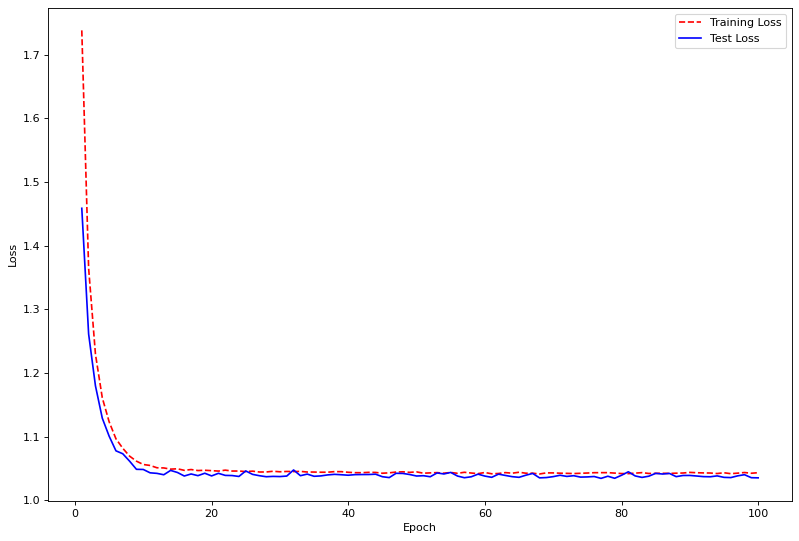

In [19]:
hist = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=2)
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

training_loss = hist.history['loss']
test_loss = hist.history['val_loss']

epoch = range(1, len(training_loss) + 1)

fig=plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(epoch, training_loss, 'r--')
plt.plot(epoch, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [20]:
y_pred_RN_3 = model.predict(X_test, verbose=0, )

2023-03-20 12:01:11.801243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [21]:
# On convertit les probabilités estimées pour chaque classe par
# le réseau de neurones en un vecteur de classes prédites
y_pred_RN = []
for i in range(len(y_pred_RN_3)):
    maxi = max(y_pred_RN_3[i])
    if y_pred_RN_3[i][0] == maxi:
        y_pred_RN.append(0)
    if y_pred_RN_3[i][1] == maxi:
        y_pred_RN.append(1)
    if y_pred_RN_3[i][2] == maxi:
        y_pred_RN.append(2)

## Statistiques

On affiche l'**accuracy** de chaque modèle

In [22]:
print("Accuracy du LogisticRegression:", accuracy_RL)
print("Accuracy du DecisionTreeClassifier:", accuracy_DT)
print("Accuracy du KNeighborsClassifier:", accuracy_KNN)
print("Accuracy du RandomForestClassifier:", accuracy_RF)
print("Accuracy du SVMClassifier:", accuracy_SVM)
print("Accuracy du XGBoostClassifier:", accuracy_XGB)
print("Accuracy du Réseau de Neurones:", test_acc)

Accuracy du LogisticRegression: 0.45524017467248906
Accuracy du DecisionTreeClassifier: 0.38471615720524016
Accuracy du KNeighborsClassifier: 0.4080786026200873
Accuracy du RandomForestClassifier: 0.4351528384279476
Accuracy du SVMClassifier: 0.45065502183406114
Accuracy du XGBoostClassifier: 0.43820960698689954
Accuracy du Réseau de Neurones: 0.4537118077278137


On affiche l'**accuracy** de chaque modèle après une KFold Cross Validation

In [23]:
print('KFold Cross Validation')
print("Accuracy du LogisticRegression:", accuracy_RL_cross)
print("Accuracy du DecisionTreeClassifier:", accuracy_DT_cross)
print("Accuracy du KNeighborsClassifier:", accuracy_KNN_cross)
print("Accuracy du RandomForestClassifier:", accuracy_RF_cross)
print("Accuracy du SVMClassifier:", accuracy_SVM_cross)
print("Accuracy du XGBoostClassifier:", accuracy_XGB_cross)

KFold Cross Validation
Accuracy du LogisticRegression: 0.45269936514808923
Accuracy du DecisionTreeClassifier: 0.3808525535695042
Accuracy du KNeighborsClassifier: 0.4050052117555844
Accuracy du RandomForestClassifier: 0.43431186229902796
Accuracy du SVMClassifier: 0.4510394828791055
Accuracy du XGBoostClassifier: 0.43562202040643105


### Matrices de confusion

Régression Logistique

<Axes: >

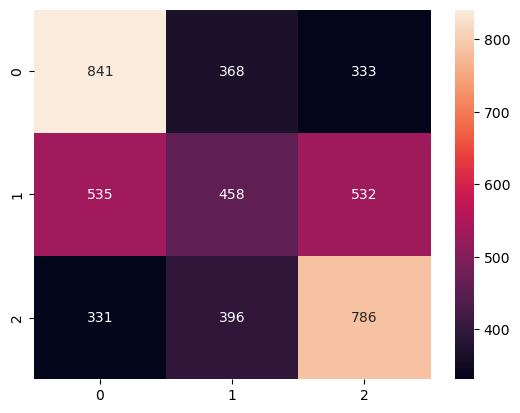

In [24]:
cm = confusion_matrix(y_test, y_pred_RL)
sns.heatmap(cm, annot=True, fmt='d')

Decision Tree

In [ ]:
cm = confusion_matrix(y_test, y_pred_DT)
sns.heatmap(cm, annot=True, fmt='d')

KNN

In [ ]:
cm = confusion_matrix(y_test, y_pred_KNN)
sns.heatmap(cm, annot=True, fmt='d')

Random Forest

In [ ]:
cm = confusion_matrix(y_test, y_pred_RF)
sns.heatmap(cm, annot=True, fmt='d')

On affiche l'imortance de chaque feature pour ce modèle en %

In [ ]:
plt.bar(x=df.columns,height=clf_RF.feature_importances_*100,width=0.5,bottom=None, align='center')
plt.xticks(range(len(df.columns)), df.columns, rotation='vertical')
plt.show()

SVM

In [ ]:
cm = confusion_matrix(y_test, y_pred_SVM)
sns.heatmap(cm, annot=True, fmt='d')

XGBoost

In [ ]:
cm = confusion_matrix(y_test, y_pred_XGB)
sns.heatmap(cm, annot=True, fmt='d')

Réseau de Neurones

In [ ]:
cm = confusion_matrix(y_test, y_pred_RN)
sns.heatmap(cm, annot=True, fmt='d')

On affiche l'imortance de chaque feature pour ce modèle en %

In [ ]:
bestfeatures = SelectKBest(score_func=mutual_info_classif, k='all')
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(100*fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']

print(featureScores.nlargest(41,'Score'))

## Résultats Financiers

Fonction calculant le gain par modèle si on se fie à ses prédictions en misant sur chaque match une somme `mise`.

Le gain est calculé en retirant la mise initiale, pour ne garder que le profit.

In [25]:
def calculgain(mise, pred):
    df_final = pd.DataFrame()
    df_final['Résultat'] = y_test
    df_final['Prédiction'] = pred
    df_final = pd.merge(df_equipe[['WHH','WHD','WHA']].reset_index(), df_final.reset_index(), on='index')
    df_final['Résultat'] = df_final['Résultat'].astype('int')
    df_final = df_final.drop(['index'], axis=1)

    gain = []
    cote = []
    for index, row in df_final.iterrows():
        if df_final.iloc[index]['Résultat'] == df_final.iloc[index]['Prédiction']:
            if df_final.iloc[index]['Résultat'] == encoded_dict['H']:
                gain.append(mise*df_final.iloc[index]['WHH']-mise)
                cote.append(df_final.iloc[index]['WHH'])
            if df_final.iloc[index]['Résultat'] == encoded_dict['D']:
                gain.append(mise*df_final.iloc[index]['WHD']-mise)
                cote.append(df_final.iloc[index]['WHD'])
            if df_final.iloc[index]['Résultat'] == encoded_dict['A']:
                gain.append(mise*df_final.iloc[index]['WHA']-mise)
                cote.append(df_final.iloc[index]['WHA'])
        else:
            gain.append(-10)

    print(f'Somme gagnée en misant {mise}€ sur chaque match : {round(sum(gain),2)}€')
    print(f'Somme gagnée par match : {round(np.mean(gain),2)}€')
    print(f'Moyenne des cotes validées : {round(np.mean(cote),2)}')
    print(f'Nombre de paris validés : {len(cote)}')

On affiche les gains pour chaque modèle

In [26]:
mise = 10

print('LogisticRegressionClassifier :')
calculgain(mise, y_pred_RL)
print()
print('DecisionTreeClassifier :')
calculgain(mise, y_pred_DT)
print()
print('KNeighborsClassifier :')
calculgain(mise, y_pred_KNN)
print()
print('RandomForestClassifier :')
calculgain(mise, y_pred_RF)
print()
print('SVMClassifier :')
calculgain(mise, y_pred_SVM)
print()
print('XGBoostClassifier :')
calculgain(mise, y_pred_XGB)
print()
print('Réseau de Neurones :')
calculgain(mise, y_pred_RN)

LogisticRegressionClassifier :
Somme gagnée en misant 10€ sur chaque match : 18647.61€
Somme gagnée par match : 5.59€
Moyenne des cotes validées : 3.4
Nombre de paris validés : 1528

DecisionTreeClassifier :
Somme gagnée en misant 10€ sur chaque match : 11174.81€
Somme gagnée par match : 3.35€
Moyenne des cotes validées : 3.45
Nombre de paris validés : 1293

KNeighborsClassifier :
Somme gagnée en misant 10€ sur chaque match : 14877.7€
Somme gagnée par match : 4.46€
Moyenne des cotes validées : 3.57
Nombre de paris validés : 1353

RandomForestClassifier :
Somme gagnée en misant 10€ sur chaque match : 16011.31€
Somme gagnée par match : 4.8€
Moyenne des cotes validées : 3.43
Nombre de paris validés : 1440

SVMClassifier :
Somme gagnée en misant 10€ sur chaque match : 19298.31€
Somme gagnée par match : 5.78€
Moyenne des cotes validées : 3.47
Nombre de paris validés : 1517

XGBoostClassifier :
Somme gagnée en misant 10€ sur chaque match : 18039.11€
Somme gagnée par match : 5.4€
Moyenne des 